# **Titanic Practice**

This notebook is about the famous Titanic dataset analysis.
Classification is done by Scikit's Gradient Boosting Algorithm.

The train dataset is first cleaned before being used. It consist of:

1. EDA for each variables
2. Remove NaNs
3. Drop highly correlated variables to reduce multicollinearity
4. Check the beta value of logistic regression to perform T test for each variables.
5. Use gradient boosting model to get the final result

In [3]:
import pandas as pd

data = pd.read_csv('train.csv')
data.head()

data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
data = data.astype({'Embarked':str})
data = data.dropna()
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for i in data.columns:
    print(i)
    plt.hist(data[i], bins=10)
    plt.title(i)
    plt.show()

In [ ]:
# Remove Outliers

contains_outliers = []
print(len(data))
print(data.head())

for i in ['Age', 'SibSp', 'Parch', 'Fare']:
    q1 = data[i].quantile(0.16)
    q3 = data[i].quantile(0.84)
    diff = q3 - q1

    contains_outliers = contains_outliers + [*data[(data[i] < q1 - 2*diff) | (data[i] > q3 + 2*diff)].index]

print(contains_outliers)
data = data.drop(contains_outliers)
print(len(data))

659
   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_C  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False        True   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_Q  
0       False  
1       False  
2       False  
3       False  
4       False  
[16, 50, 68, 119, 164, 171, 182, 233, 261, 266, 278, 541, 542, 686, 787, 813, 824, 850, 167, 360, 567, 307, 505, 537, 544]
634


In [28]:
data = data.dropna()

data = pd.get_dummies(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0,3,22.0,1,0,7.2500,False,True,False,False,True,False
1,1,1,38.0,1,0,71.2833,True,False,True,False,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True,False
3,1,1,35.0,1,0,53.1000,True,False,False,False,True,False
4,0,3,35.0,0,0,8.0500,False,True,False,False,True,False


In [29]:
data = data.drop(columns=['Embarked_nan'])

<Axes: >

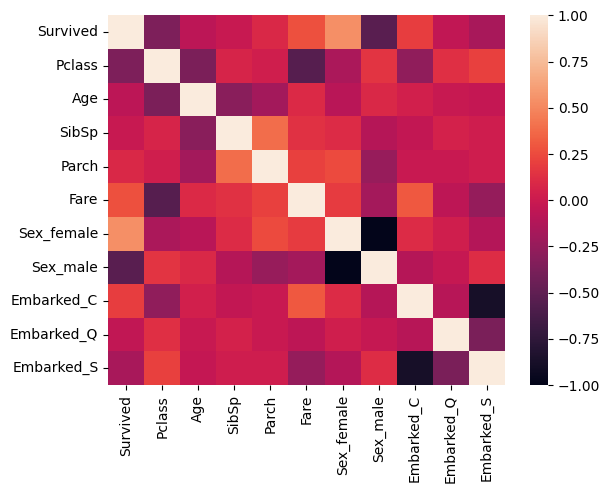

In [30]:
import seaborn as sns
sns.heatmap(data.corr())

In [31]:
# Remove highly correlated independent variables
# Sex_female and Sex_male are definitely correlated, so drop one of them
# Embarked_C and Embarked_S are strongly correlated so drop one of them
data = data.drop(columns=['Sex_female', 'Embarked_S'])

<Axes: >

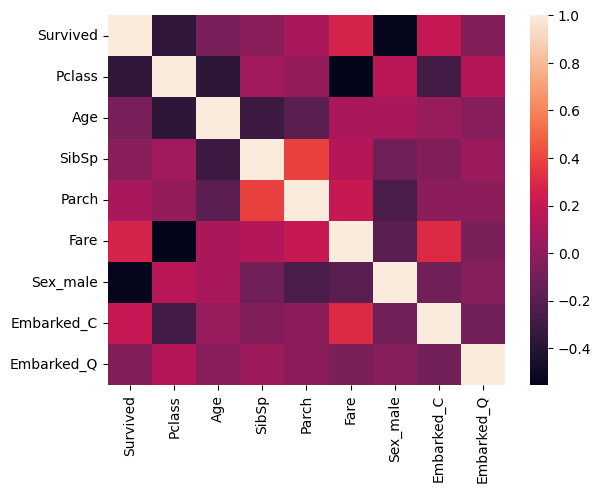

In [32]:
import seaborn as sns
sns.heatmap(data.corr())

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_C', 'Embarked_Q'],
      dtype='object')


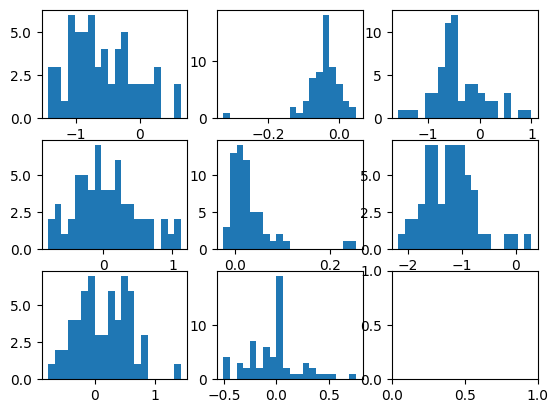

In [33]:
# Number of iteration to get the distribution of beta coefficients
iter = 60

from sklearn.linear_model import LogisticRegression
print(data.columns)
params = np.zeros((iter, len(data.columns)-1))

for i in range(iter):
    sample = data.sample(n=30)
    model = LogisticRegression(max_iter=1000)
    #print(sample.drop(columns=['Survived']))
    model.fit(sample.drop(columns=['Survived']), sample['Survived'])
    params[i] = model.coef_

fig, axs = plt.subplots(3, 3)
axs[0, 0].hist(params[:,0], bins=20)
axs[0, 1].hist(params[:,1], bins=20)
axs[0, 2].hist(params[:,2], bins=20)
axs[1, 0].hist(params[:,3], bins=20)
axs[1, 1].hist(params[:,4], bins=20)
axs[1, 2].hist(params[:,5], bins=20)
axs[2, 0].hist(params[:,6], bins=20)
axs[2, 1].hist(params[:,7], bins=20)
plt.show()

In [34]:
# perform the T test for each parameters
# (mean-0(null hypo)) / Standard error

for i in range(len(params[0])):
    print(f'T value : {np.mean(params[:,i])/(np.std(params[:,i])/1000**0.5)}')

T value : -35.73630624017969
T value : -26.431951521882155
T value : -26.343790639691324
T value : 3.162297760230061
T value : 19.23999638139915
T value : -82.94807390073714
T value : 10.028508797246626
T value : -3.8060813066392107


In [38]:
# perform the F test for each parameters

from sklearn.ensemble import GradientBoostingClassifier as GBC
import math
sigmoid = lambda x: 1/(1+math.exp(-x))

model = GBC()
model.fit(data.drop(columns=['Survived']), data['Survived'])
print(model.coef_, model.intercept_)

SSR = np.sum((sigmoid(model.intercept_) - data['Survived'])**2)
SSUR = np.sum((model.predict(data.drop(columns=['Survived'])) - np.mean(data['Survived']))**2)

print(SSR, SSUR)

print(((SSR-SSUR)/(len(data.columns)-1))/(SSUR/(iter-(len(data.columns)-1)-1)))

[[-1.15517277e+00 -4.19422156e-02 -3.45175570e-01 -5.90712067e-02
   1.76142494e-03 -2.52517730e+00  3.61442742e-01 -4.39522276e-01]] [5.02043979]
418.46924887851424 167.52100840336135
9.549817352920133


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-38-b4cf2822296e>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigmoid = lambda x: 1/(1+math.exp(-x))


In [39]:
data = data.loc[:, ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_C', 'Embarked_Q']]
print(data.columns)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_C', 'Embarked_Q'],
      dtype='object')


In [78]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
model = GBC()
model.fit(data.drop(columns=['Survived']), data['Survived'])

GradientBoostingClassifier()

In [ ]:
print(data.columns)

Index(['Survived', 'Pclass', 'SibSp', 'Age', 'Fare', 'Sex_male'], dtype='object')


In [79]:
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Titanic/test.csv')
pid = data_test['PassengerId']
print(pid)
data_test = data_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

data_test = pd.get_dummies(data_test)
data_test = data_test.loc[:, ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_C', 'Embarked_Q']]
print(data_test.columns)

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_C',
       'Embarked_Q'],
      dtype='object')


In [80]:
# data_test = data_test.drop(columns=['SibSp', 'Parch', 'Embarked_C', 'Embarked_Q',])
# data_test = data_test.drop(columns=[ 'Sex_female', 'Embarked_S'])
# data_test = data_test.dropna()
# data_test.head()
print(data_test.isna().sum())
data_test['Age'].fillna(data_test['Age'].mean(), inplace=True)
data_test['Fare'].fillna(data_test['Age'].mean(), inplace=True)
print(data_test.isna().sum())

Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_male       0
Embarked_C     0
Embarked_Q     0
dtype: int64
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_C    0
Embarked_Q    0
dtype: int64


In [81]:
result = model.predict(data_test)
result = pd.DataFrame(result)
result = pd.concat([pid, result], axis=1, ignore_index=True)
result.columns = ['PassengerId', 'Survived']
result.to_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/Titanic/result.csv', index=False)

# Final submission result : 0.77751